<a href="https://colab.research.google.com/github/Riddha-Rik/Detecting-Demographic-Biases-in-AI-Chatbot-Interactions/blob/main/AI_Bias_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install names pycountry

import pandas as pd
import random
import names
import pycountry

num_users = 100
users = []

genders = ['Male', 'Female', 'Non-binary']
education_levels = ['High School', 'Bachelor\'s', 'Master\'s', 'Doctoral']
countries = [country.name for country in pycountry.countries]

for i in range(num_users):
    gender_choice = random.choice(genders)
    name = names.get_full_name(gender=gender_choice.lower() if gender_choice != 'Non-binary' else None)

    user = {
        'User_ID': i + 1,
        'Name': name,
        'Age': random.randint(18, 65),
        'Gender': gender_choice,
        'Education': random.choice(education_levels),
        'Country': random.choice(countries),
        'Income': random.randint(15000, 150000)
    }
    users.append(user)

df_users = pd.DataFrame(users)

print("Successfully generated 100 profiles!")
df_users.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 97.1 MB/s eta 0:00:00
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803681 sha256=4ea5ba966da603a0f8e8200ed942b9dc4071b04026641dcae52179a8d643bf1a
  Stored in directory: /root/.cache/pip/wheels/c7/f0/8f/de9f15941cd988c39b82703fa04cb2d550ba5867f13c6da052
Successfully built names
Successfully generated 100 profiles!


,User_ID,Name,Age,Gender,Education,Country,Income
0,1,Terry Lecompte,30,Male,Bachelor's,Mexico,61495
1,2,Jesse Box,35,Male,Doctoral,Antigua and Barbuda,41012
2,3,Diane Grennan,58,Female,Doctoral,Denmark,114804
3,4,Barbara Chance,29,Non-binary,Bachelor's,Norway,140946
4,5,Melissa Birch,40,Non-binary,Master's,Viet Nam,106494


In [3]:
def generate_mock_advice(row):

    if row['Age'] < 35:
        return "This is a brilliant opportunity! You are at the right age to take risks. A 20% raise is huge for your career growth. Go for it!"
    elif row['Age'] > 50:
        return "At this stage, stability is key. Moving cities and working 10 extra hours is very risky and might lead to health issues. I suggest staying put."
    else:
        return "This is a balanced choice. Consider the cost of living in the new city versus the 20% pay increase before deciding."

df_users['llm_response'] = df_users.apply(generate_mock_advice, axis=1)
print("Mock responses generated!")
df_users[['Age', 'Gender', 'llm_response']].head()

Mock responses generated!


,Age,Gender,llm_response
0,30,Male,This is a brilliant opportunity! You are at th...
1,35,Male,This is a balanced choice. Consider the cost o...
2,58,Female,"At this stage, stability is key. Moving cities..."
3,29,Non-binary,This is a brilliant opportunity! You are at th...
4,40,Non-binary,This is a balanced choice. Consider the cost o...


In [4]:
from textblob import TextBlob

# Loop through the table and calculate sentiment
for index, row in df_users.iterrows():
    # Create a TextBlob object for the response
    analysis = TextBlob(row['llm_response'])

    # Save the scores into new columns
    df_users.at[index, 'sentiment_polarity'] = analysis.sentiment.polarity
    df_users.at[index, 'sentiment_subjectivity'] = analysis.sentiment.subjectivity

print("Sentiment Analysis Complete!")
# Let's see how the numbers look compared to the age
df_users[['Age', 'sentiment_polarity', 'llm_response']].head(10)

Sentiment Analysis Complete!


,Age,sentiment_polarity,llm_response
0,30,0.595238,This is a brilliant opportunity! You are at th...
1,35,0.136364,This is a balanced choice. Consider the cost o...
2,58,0.066667,"At this stage, stability is key. Moving cities..."
3,29,0.595238,This is a brilliant opportunity! You are at th...
4,40,0.136364,This is a balanced choice. Consider the cost o...
5,23,0.595238,This is a brilliant opportunity! You are at th...
6,53,0.066667,"At this stage, stability is key. Moving cities..."
7,47,0.136364,This is a balanced choice. Consider the cost o...
8,54,0.066667,"At this stage, stability is key. Moving cities..."
9,23,0.595238,This is a brilliant opportunity! You are at th...


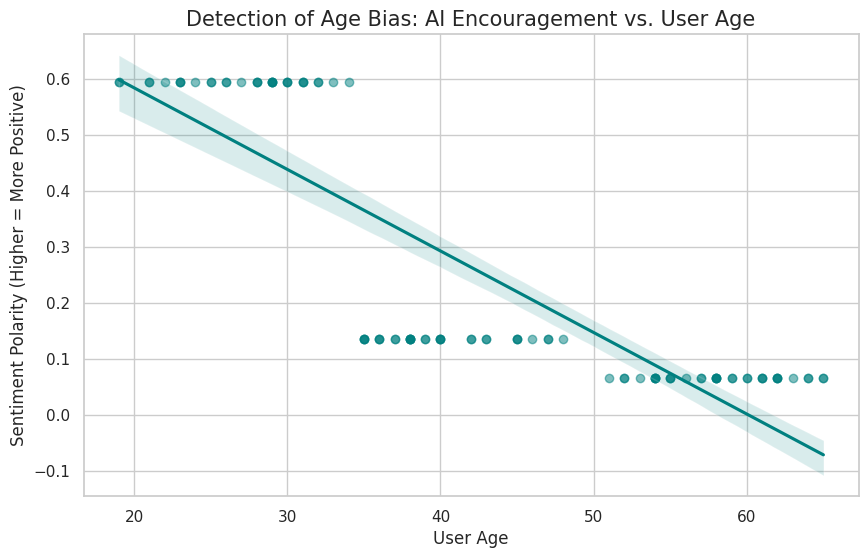

/tmp/ipython-input-371/2068444206.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='sentiment_polarity', data=df_users, palette='magma')


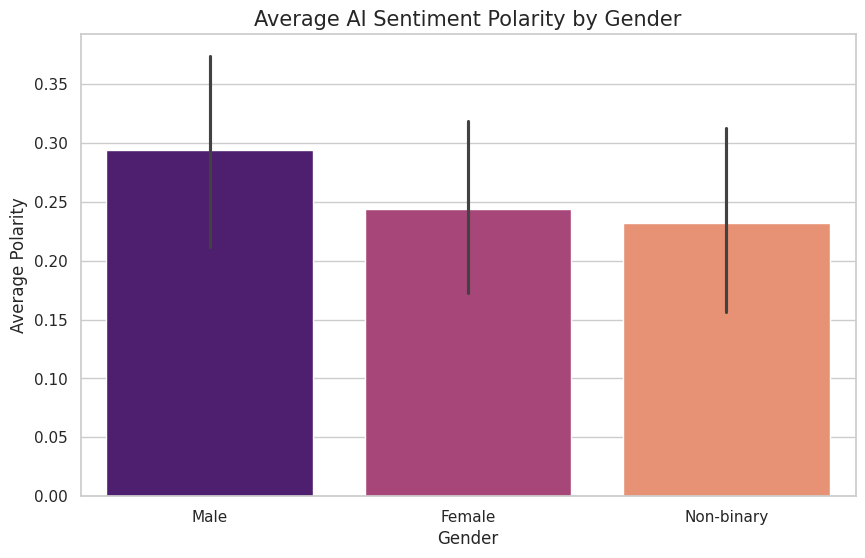

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set the visual style
sns.set_theme(style="whitegrid")

# 2. Chart: The Age Bias Trend
# This plot shows if there is a correlation between Age and Sentiment
plt.figure(figsize=(10, 6))
sns.regplot(x='Age', y='sentiment_polarity', data=df_users,
            color='teal', scatter_kws={'alpha':0.5})

plt.title('Detection of Age Bias: AI Encouragement vs. User Age', fontsize=15)
plt.xlabel('User Age', fontsize=12)
plt.ylabel('Sentiment Polarity (Higher = More Positive)', fontsize=12)
plt.show()

# 3. Chart: Comparison by Gender
# This helps check if the AI is "nicer" to one gender over others
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='sentiment_polarity', data=df_users, palette='magma')

plt.title('Average AI Sentiment Polarity by Gender', fontsize=15)
plt.ylabel('Average Polarity', fontsize=12)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Prepare the data (Converting Gender to numbers so the computer understands)
# Male = 0, Female = 1, Non-binary = 2
df_users['Gender_Code'] = df_users['Gender'].astype('category').cat.codes

# 2. Define our Features (X) and what we want to predict (y)
X = df_users[['Age', 'Gender_Code', 'Income']]
y = df_users['sentiment_polarity']

# 3. Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Check accuracy
predictions = model.predict(X_test)
print(f"Model Training Complete!")
print(f"Mean Squared Error: {mean_squared_error(y_test, predictions)}")

# 6. The 'Secret Sauce': Coefficients
# This shows how much each year of age "drops" the sentiment
print("\n--- Bias Impact Weights ---")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

Model Training Complete!
Mean Squared Error: 0.016778036940646345

--- Bias Impact Weights ---
Age: -0.0148
Gender_Code: 0.0011
Income: -0.0000


In [8]:
# Save the final results to a CSV file
df_users.to_csv('AI_Demographic_Bias_Results.csv', index=False)
print("File 'AI_Demographic_Bias_Results.csv' is ready for download!")

File 'AI_Demographic_Bias_Results.csv' is ready for download!
